In [371]:
import re
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from scipy.stats import iqr
from scipy.stats import binned_statistic
import cmastro
import math

### GJ1214 Data - taken from the Auxillary-port CAMera (ACAM) on the William Herschel Telescope (WHT)

In [373]:
path = '/Users/ChanFamily/AST326-Practical-Astronomy/Lab5_ACAM_DATA/'

hdul1 = fits.open(path + 'r1598072.fit') # load data 
header = hdul1[0].header
flat1 = hdul1[1].data

# FLAT
with open("filelist.txt", "r") as f:
    flist = f.read()
    flist = re.split(" |\n", flist)
    flat = []
    for file in flist:
        if '.fit' in file and ( int(file[4:8]) in range(8072, 8090) or int(file[4:8]) in range(9966, 9995) ): 
            hdulist = fits.open(path + file)
            
            # normalize the flats 
            normalized_flat = (hdulist[1].data / np.max(hdulist[1].data)) * np.max(flat1) #normalize all the flat frames to have the same flux as the first flat
            flat.append(normalized_flat) # do what needs to be done here 
            hdulist.close()

master_flat = np.median(np.array(flat), axis=0).astype(int) # MASTER FLAT

In [374]:
# BIAS
with open("filelist.txt", "r") as f:
    flist = f.read()
    flist = re.split(" |\n", flist)
    bias = []
    for file in flist:
        if '.fit' in file and ( int(file[2:8]) in range(599995, 600020) ): 
            hdulist = fits.open(path + file)
            bias.append(hdulist[1].data) # do what needs to be done here 
            hdulist.close()

master_bias = np.median(np.array(bias), axis=0).astype(int) # MASTER BIAS

In [375]:
# TARGET
with open("filelist.txt", "r") as f:
    flist = f.read()
    flist = re.split(" |\n", flist)
    target_images = []
    time_headers = []
    for file in flist:
        if '.fit' in file and int(file[4:8]) in range(9579, 9943): 
            hdulist = fits.open(path + file)
            target_images.append(hdulist[1].data) # do what needs to be done here      
            time_headers.append(hdulist[0].header)
            hdulist.close()

master_target = np.median(np.array(target_images), axis=0).astype(int) # MASTER TARGET
#target_images = np.array(target_images)
#time_headers= np.array(time_headers)

Text(0.5, 1.0, 'Master Target')

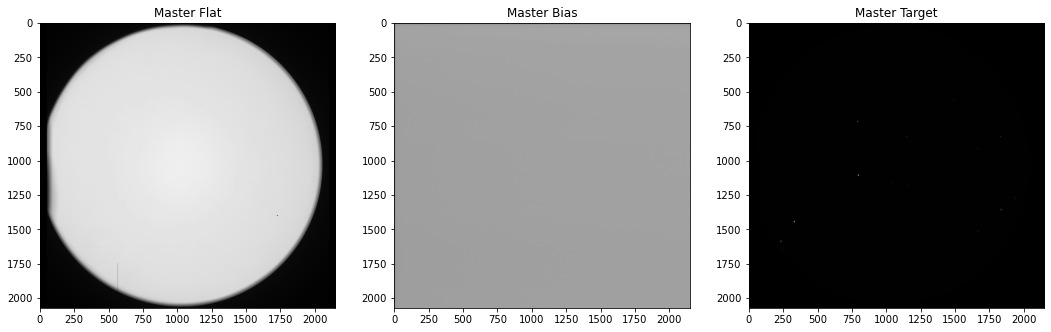

In [411]:
fig, ax = plt.subplots(figsize=(18,8), nrows=1, ncols=3)
ax[0].imshow(master_flat, cmap='gray')
ax[0].set_title("Master Flat")
ax[1].imshow(master_bias, cmap='gray')
ax[1].set_title("Master Bias")
ax[2].imshow(master_target, cmap='gray')
ax[2].set_title("Master Target")

### Below we create a masking function 

In [5]:
# create a circular mask function 

def mask(height, width, center=None, radius=None):
    
    if center == None:
        center = (int(width/2), int(height/2))
    if radius == None:
        radius = min(center[0], center[1], width - center[0], height - center[1])
        
    y, x = np.ogrid[:height, :width]
    radial_dist = np.sqrt((y - center[0])**2 + (x - center[1])**2)
    
    mask_array = radial_dist <= radius
    return ~mask_array

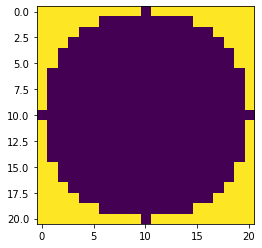

In [6]:
plt.imshow(mask(21,21))
#mask(21,21)

### Apply the masking function to the flat frame

In [7]:
# Below we mask the three frames and then normalize the flat field image
masked = master_flat < 2000 # our mask
master_masked_flat = np.ma.masked_array(master_flat, masked)

normalized_master_masked_flat = master_masked_flat 

### Corrected resulting image

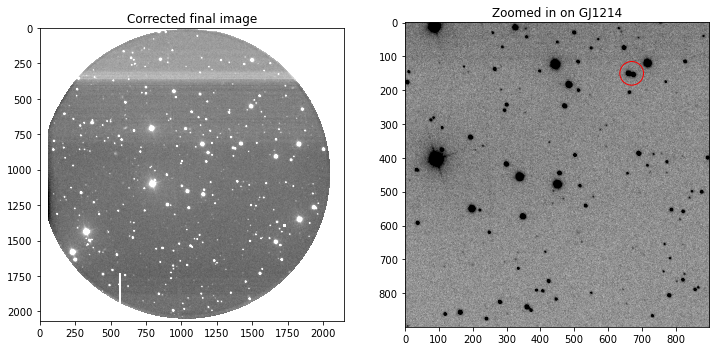

In [419]:
# Rotate image to match Aladin image
#import scipy.ndimage as ndimage
#angle = -90

hdul1 = fits.open(path + 'r1599852.fit') # load data 
header = hdul1[0].header
image1 = hdul1[1].data

# Next we combine the flat, bias and target frames by subtracting the bias and dividing by the flat
corrected = (image1 - master_bias) / normalized_master_masked_flat
#corrected_target = ndimage.rotate(corrected, angle)
#corrected_mask = ndimage.rotate(masked, angle)
#corrected_target = np.ma.masked_array(corrected_image, corrected_mask)

# image mask
#image_mask = image1 < 

#corrected_target = np.ma.masked_array(corrected, masked)

vmin, vmax = 2.3*10e-3, 3*10e-3 #5.6*10e4, 7*10e4 

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
circle = plt.Circle((670, 150), 35, fill=False, color='r')

ax[0].imshow(corrected, cmap='gray', norm=LogNorm(vmin, vmax))
ax[0].set_title("Corrected final image")
ax[1].imshow(corrected[700:1600,700:1600], cmap='binary', norm=LogNorm(vmin, vmax))
ax[1].set_title("Zoomed in on GJ1214")
ax[1].add_artist(circle)
fig.savefig("Corrected.pdf")

# Here we can check if the background of our image is close to zero
background_mask = corrected_target > np.ma.median(corrected_target) # remove bright images 
background_array = np.ma.masked_array(corrected_target, background_mask)

print("Background: ", np.ma.median(background_array))

## Identifying GJ1214 in the first FITS image

In [276]:
hdul1 = fits.open(path + 'r1599664.fit') # load data 
header = hdul1[0].header
image1 = hdul1[1].data

#masked_data = np.ma.masked_array(image1, masked)
#image1 = (masked_data - master_bias) / normalized_master_masked_flat

In [1316]:
header['JD']

2455704.5038657

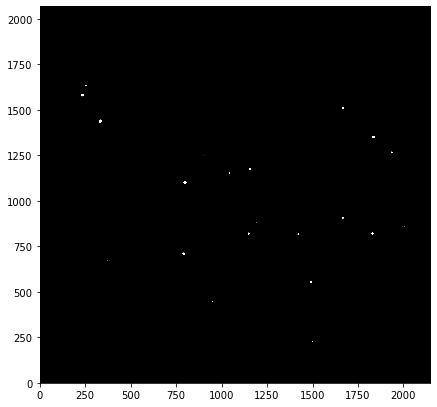

In [1322]:
# Corrected image using master flat and bias
plt.figure(figsize=(7, 7))
plt.imshow(image1, cmap='gray', norm=LogNorm(3*10e2, 4*10e2)) 
ax = plt.gca()
ax.invert_yaxis()

### Tutorial Notes

Noise is not constant, cannot precisely determine.
* readout noise is average photons for example you get each time
* variation mainly due to read out noise, sky background noise and dark noise

Aperture photometry
* annulus used to est the background level and avg pixel noise (readout, background and dark noise)
* stellar flux = entire flux inside object aperature - 

Principles of photometry
* total flux from star: 
* sky annulus used as sky backround noise that you subtract from the mean pixel value that you get in the source aperature ring where the star is contained
* stellar flux, total flux insice source aperature - # of pixels in source aperature - sky annulus background noise
$$ \text{source uncertainty} = \frac{\sqrt{G F_n}}{G}$$ where G is the CCD gain
$$ \text{stelllar flux uncertainty} = \sqrt{N \sigma_{BG}}$$ where N is number of pixels in source aperature and BG is background noise

signal to noise curve for radius finding 

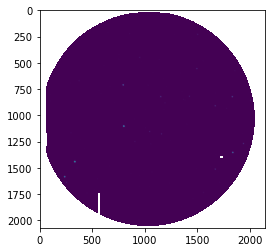

In [279]:
plt.imshow(corrected)

## Reference star finding 

In [379]:
def centroid(data):
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[0])
    cx = np.sum(x*data) / np.sum(data)
    cy = np.sum(y*data.T) / np.sum(data)
    
    return np.array([cx, cy])

In [412]:
background = np.ma.median(corrected)
pixel_pos = []
box_size = 20
data_copy = corrected.copy()

number_of_stars = 20

for i in range(number_of_stars):
    #find brightest pixel in the image
    brightest_pixel = np.array([np.where(data_copy == np.max(data_copy))[0][0], np.where(data_copy == np.max(data_copy))[1][0]])
    
    if brightest_pixel[0] == 0 or brightest_pixel[1] == 0:
        continue
    
    #create a "box" around that pixel
    box = data_copy[brightest_pixel[0]-box_size : brightest_pixel[0]+box_size+1,
                    brightest_pixel[1]-box_size : brightest_pixel[1]+box_size+1]
    box -= background
    
    #Get the centroid of that box
    c = centroid(box)
    
    #Map the centroid of the box back onto the orginal image
    c -= np.array([box.shape[1]//2, box.shape[0]//2])
    c += brightest_pixel
    
    pixel_pos.append(c)
    
    #Remove that star from the image so it isn't the brightest pixel anymore
    box[:,:] = background

index = []
for k in range(len(pixel_pos) - 1):
    if pixel_pos[k][0] < 100 or pixel_pos[k][1] < 100:
        index.append(k)

for j in index:
    pixel_pos.pop(j)
        
        
stars = np.array(pixel_pos)

# Our star is located at (x,y) = (1364.62980837, 855.09493036) so we will remove it from our dataset
#stars = stars.tolist()
#target_star = stars.pop(16)
#stars = np.array(stars)

Text(0.5, 1.0, 'Reference stars')

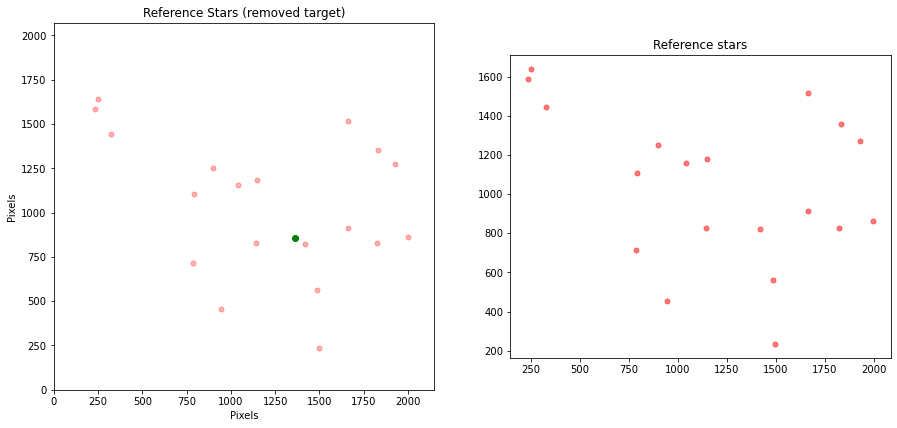

In [415]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].imshow(corrected, cmap="gray", norm=LogNorm(vmin=vmin, vmax=vmax))
ax[0].plot(stars[:,1], stars[:,0], 'o', c='r', alpha=0.3, markersize=5)
ax[0].plot(1364.62980837, 855.09493036, 'o', c='g')
#ax[0].plot(1415.8905515,  820.70712109, 'o', c='g')
ax[0].invert_yaxis()
ax[0].set_title("Reference Stars (removed target)")
ax[0].set_ylabel("Pixels")
ax[0].set_xlabel("Pixels")
ax[0].plot(1012, 0, c='r')
ax[1].plot(stars[:,1], stars[:,0], 'o', c='r', alpha=0.5, markersize=5)
#ax[1].plot(target_star[1], target_star[0], 'o', c='b')
#ax[1].plot(stars[19][1],stars[19][0], 'o', c='k')
ax[1].set_aspect('equal')
ax[1].set_title("Reference stars")

### Aperature Photometry
* we create an algorithm that takes the radius of the given star and compute its flux by subtraction of the background noise. It follows from this algorithm

$$ \text{[Stellar Flux]} = \text{[Entire Flux inside Object Aperature]} - \text{[Background Flux inside Object Aperature]} $$ 
* by finding out what the background flux is per pixel, we can multiply it by the number of pixels inside the Object Aperature and subtract that off from the Entire Flux measured inside the Object Aperature to get our true total flux from the star itself.

Star Signal: 7.641081440240864
Star Signal per pixel: 0.09433433876840573
Background Noise: 3.097695633391997
Background Noise per pixel: 0.029785534936461508
Stellar flux from star: 5.228453110387482


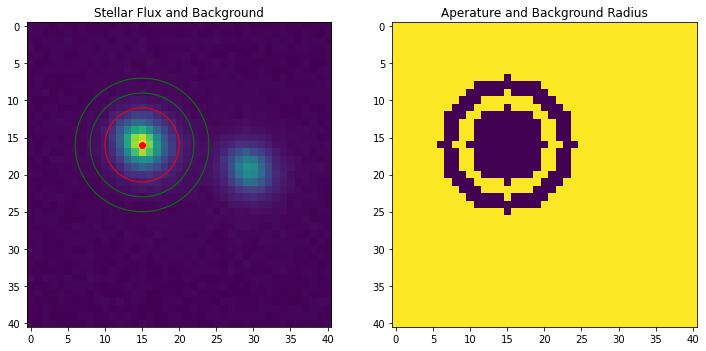

In [391]:
"""Below we create an algorithm that computes the total flux from the star (after subtraction of the background annulus)"""

# a random bright star
#target = (int(stars[4][0]), int(stars[4][1]))

# target star
target = np.array([int(855.09493036), int(1364.62980837)])
target_star = np.array([1364.62980837, 855.0949303])
# a random star
#target = (int(stars[0][0]), int(stars[0][1]))

# stars
data_copy = corrected.copy()
box = data_copy[target[0]-box_size : target[0]+box_size+1,
                target[1]-box_size : target[1]+box_size+1]

box_std = np.std(box)

# find brightest pixel in the image
brightest_pixel = np.array([np.where(box == np.max(box))[0][0], np.where(box == np.max(box))[1][0]])

# aperature size and mask 
radius = 5
star_mask = mask(len(box[:,0]), len(box[0,:]), radius=radius, center=(brightest_pixel[0], brightest_pixel[1]))
star_radius = plt.Circle((brightest_pixel[1], brightest_pixel[0]), radius, fill=False, color='r')
#star_std = np.std(box * ~star_mask)
#print(star_std)

# annulus 
outer = radius + 4
inner = radius + 2
outer_mask = mask(len(box[:,0]), len(box[0,:]), radius=outer, center=(brightest_pixel[0], brightest_pixel[1]))
inner_mask = mask(len(box[:,0]), len(box[0,:]), radius=inner, center=(brightest_pixel[0], brightest_pixel[1]))
outer_radius = plt.Circle((brightest_pixel[1], brightest_pixel[0]), outer, fill=False, color='g')
inner_radius = plt.Circle((brightest_pixel[1], brightest_pixel[0]), inner, fill=False, color='g')

annulus_mask = outer_mask == inner_mask

# signal from star and background noise (annulus)
signal_star = np.sum(box * ~star_mask)
signal_pixels = np.count_nonzero(~star_mask)
mean_signal_star = signal_star / signal_pixels # mean signal from each pixel
background_noise = np.sum(box * ~annulus_mask)
background_pixels = np.count_nonzero(~annulus_mask)
mean_background_noise = background_noise / background_pixels

print("Star Signal:", signal_star)
print("Star Signal per pixel:", mean_signal_star)
print("Background Noise:", background_noise)
print("Background Noise per pixel:", mean_background_noise)

# total flux from star
stellar_flux = signal_star - (signal_pixels * mean_background_noise)
print("Stellar flux from star:", stellar_flux)

fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=2)
ax[0].imshow(box)
ax[0].scatter(brightest_pixel[1], brightest_pixel[0], c='r')
ax[0].add_artist(star_radius)
ax[0].add_artist(outer_radius)
ax[0].add_artist(inner_radius)
ax[0].set_title("Stellar Flux and Background")
ax[1].imshow(annulus_mask == star_mask)
ax[1].set_title("Aperature and Background Radius")
fig.savefig("aperature photometry.pdf")

The max SNR is 5.0


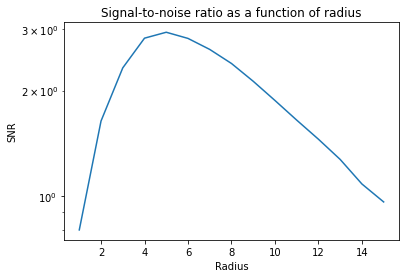

In [392]:
"""We compare the SNR as a function of radius to find the best suitable radius to use"""

radius = 15
gain = 4
snr_per_radius = []


for i in range(radius):
    # aperature mask
    star_mask = mask(len(box[:,0]), len(box[0,:]), radius=i, center=(brightest_pixel[0], brightest_pixel[1]))

    # annulus 
    outer = i + 6
    inner = i + 3
    outer_mask = mask(len(box[:,0]), len(box[0,:]), radius=outer, center=(brightest_pixel[0], brightest_pixel[1]))
    inner_mask = mask(len(box[:,0]), len(box[0,:]), radius=inner, center=(brightest_pixel[0], brightest_pixel[1]))
    
    annulus_mask = outer_mask != inner_mask
    
    # signal from star and background noise (annulus), did not include Poisson noise
    signal_star = np.sum(box * ~star_mask)
    signal_pixels = np.count_nonzero(~star_mask)
    mean_signal_star = signal_star / signal_pixels # mean signal from each pixel
    background_noise = np.sum(box * ~annulus_mask)
    background_pixels = np.count_nonzero(~annulus_mask)
    mean_background_noise = background_noise / background_pixels
    
    # total flux from star inside aperature (with background subtracted) 
    stellar_flux = signal_star - (signal_pixels * mean_background_noise)
    
    # Uncertainties
    source_unc = np.sqrt(gain * stellar_flux) / gain 
    background_unc = np.sqrt(signal_pixels * np.std(box * ~annulus_mask))
    
    stellar_unc = np.sqrt(source_unc**2 + background_unc**2)
    
    # SNR
    snr = stellar_flux / stellar_unc
    snr_per_radius.append(snr)

var_radius = np.linspace(1,radius, 15)
best_radius = var_radius[snr_per_radius.index(max(snr_per_radius))]
snr_per_radius = np.array(snr_per_radius)

print("The max SNR is", best_radius)
plt.plot(var_radius, snr_per_radius)
plt.semilogy()
plt.xlabel("Radius")
plt.ylabel("SNR")
plt.title("Signal-to-noise ratio as a function of radius") 
plt.savefig("snr plot.pdf")

Stellar flux from star: 200.10593560773674 +/- 11.908152341960644
Stellar flux from star: 243.54797291930194 +/- 13.124719207272985
Stellar flux from star: 181.98426407439126 +/- 11.446258853518717
Stellar flux from star: 222.70089517088883 +/- 12.693993477707348
Stellar flux from star: 144.3377297131758 +/- 10.350000318165009
Stellar flux from star: 92.10109302069127 +/- 8.273119543228006
Stellar flux from star: 60.47184752559076 +/- 6.730499275325792
Stellar flux from star: 55.05495600891345 +/- 6.435264581929957
Stellar flux from star: 55.63621853533647 +/- 6.43225202174535
Stellar flux from star: 52.4851955878314 +/- 6.287212059143358
Stellar flux from star: 47.880493284944485 +/- 6.005415697139945
Stellar flux from star: 36.545791145034435 +/- 5.248664648448998
Stellar flux from star: 33.18598121880306 +/- 5.004921231099504
Stellar flux from star: 29.460670367117004 +/- 4.7212394018529835
Stellar flux from star: 25.493078071869057 +/- 4.3993936842825265
Stellar flux from star: 23.

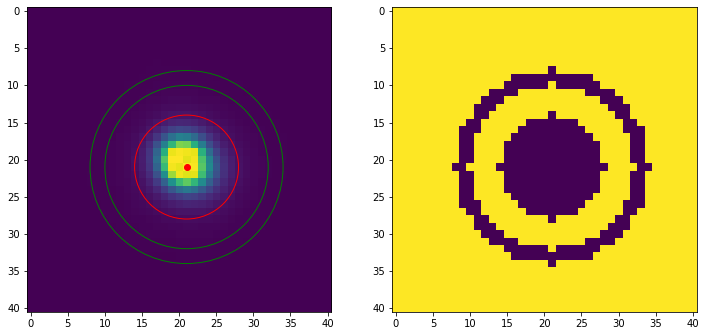

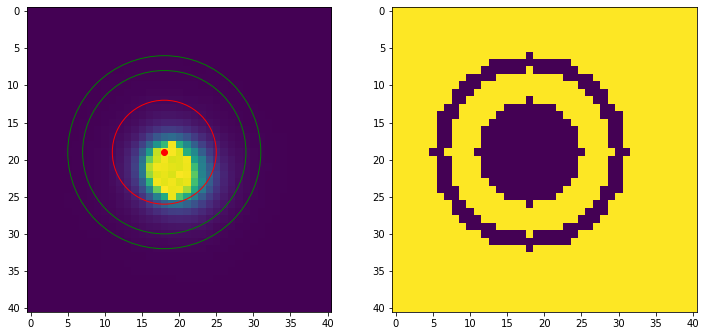

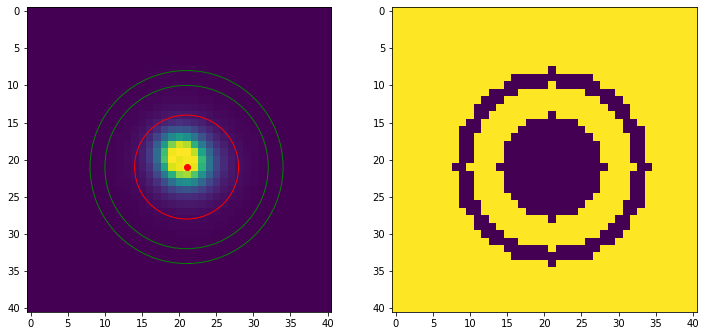

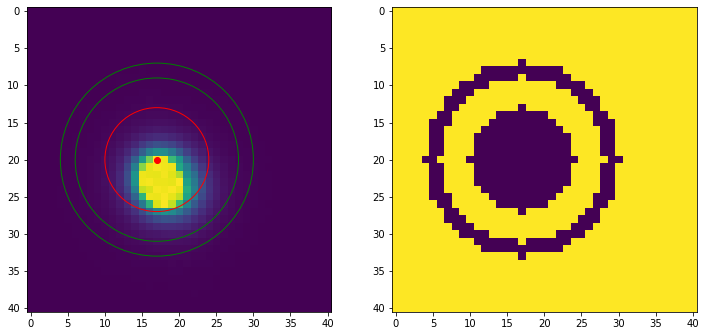

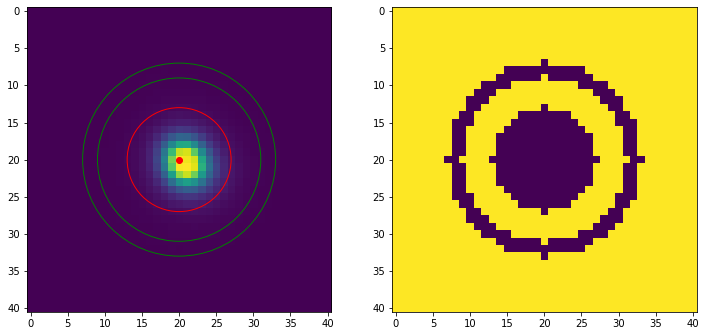

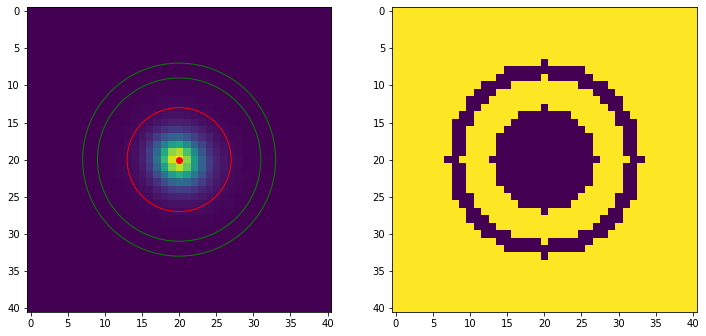

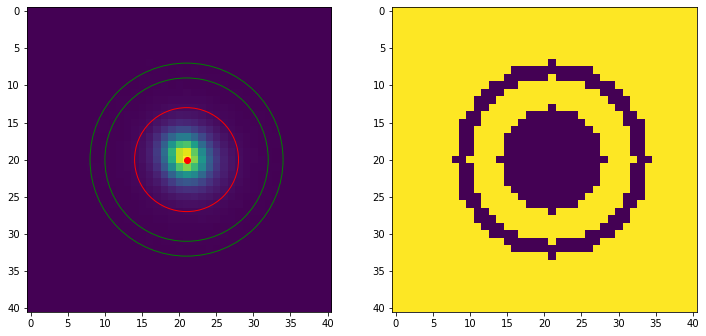

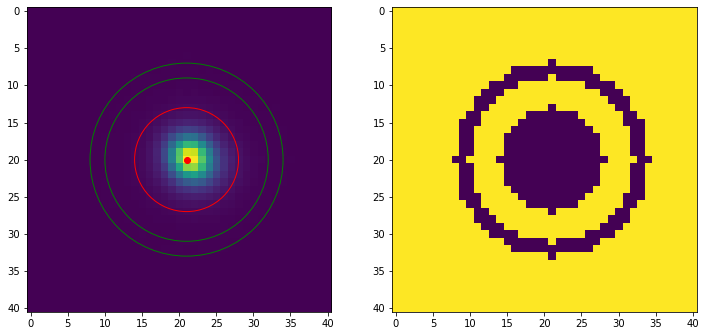

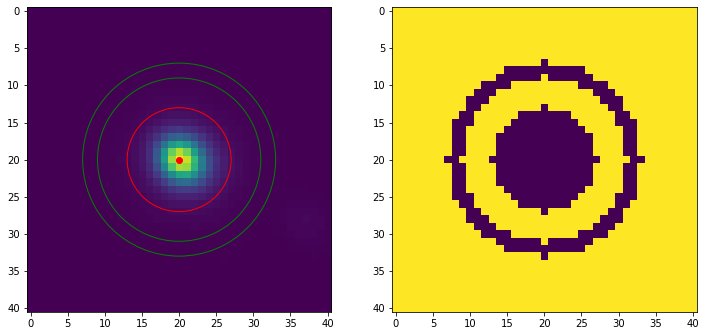

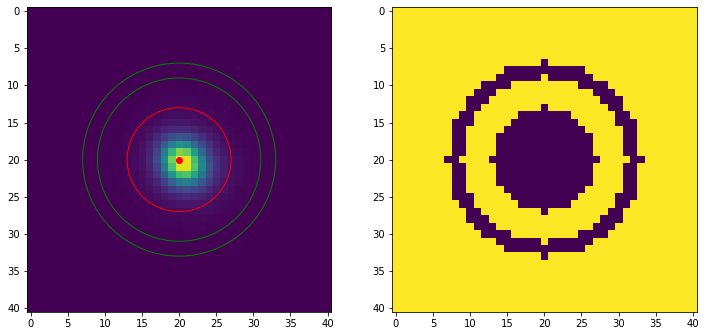

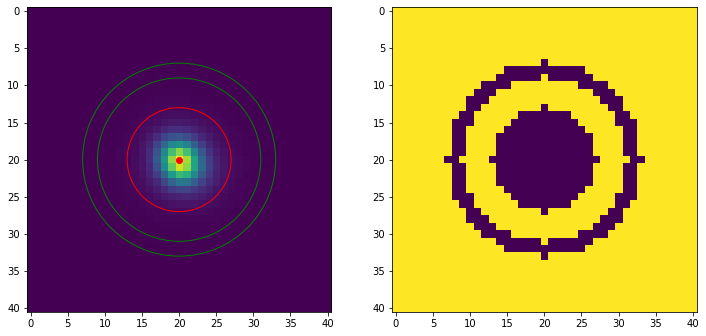

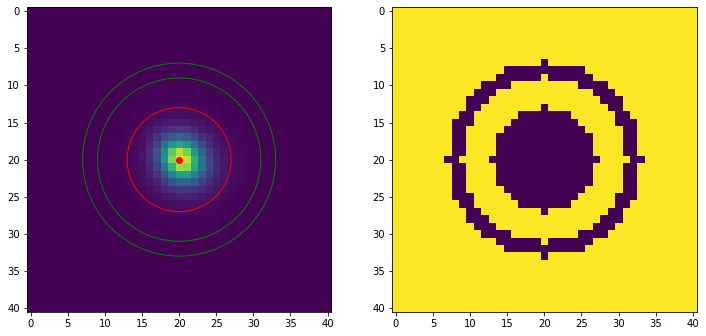

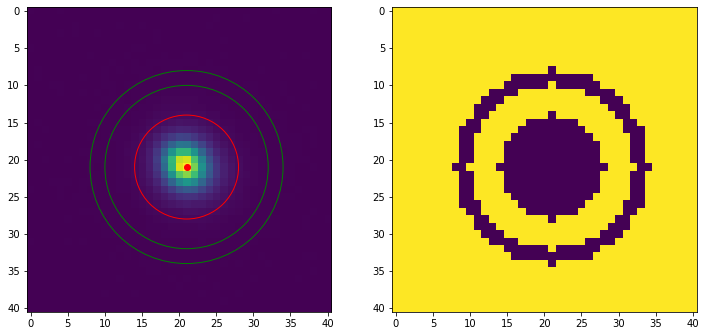

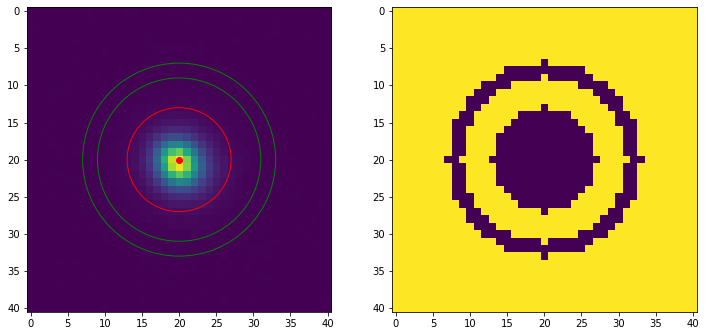

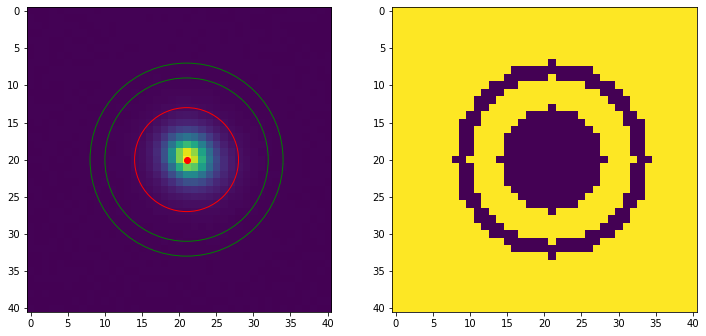

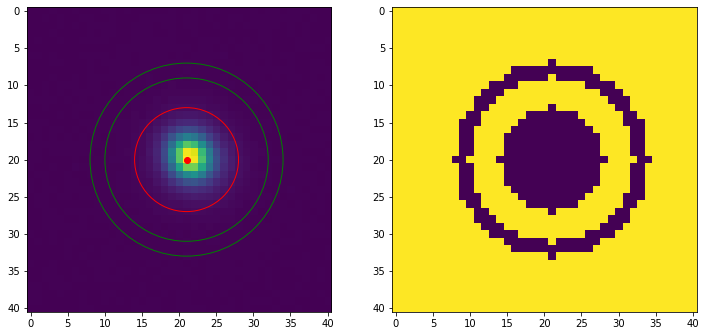

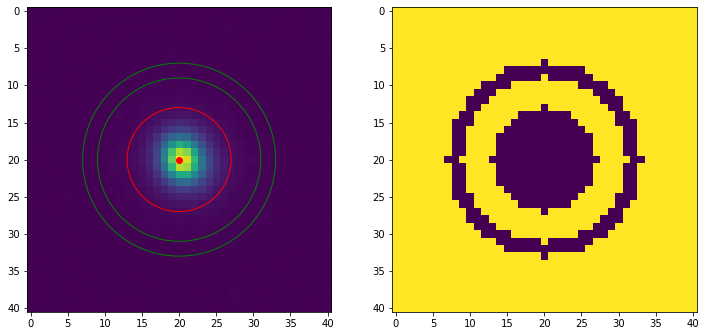

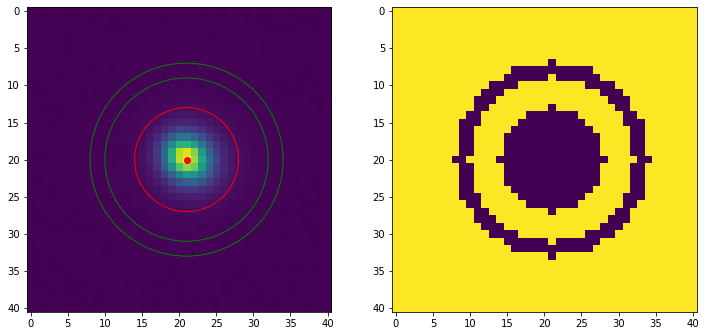

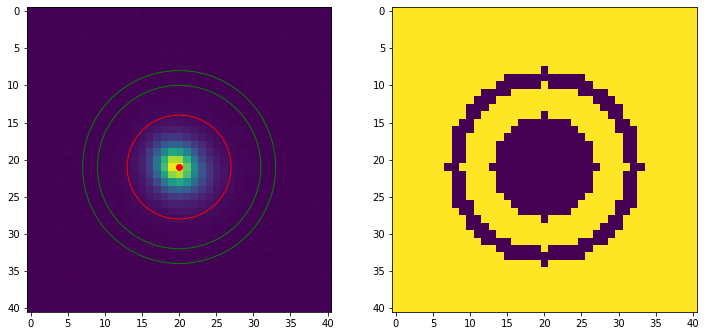

In [20]:
"""Here we look at all the reference stars in an image"""

radius = best_radius+2
reference_flux = []

for star in range(len(stars)):
    """Below we create an algorithm that computes the total flux from the star by subtracting the background annulus"""

    # a random star
    target = (int(stars[star][0]), int(stars[star][1]))

    # stars
    data_copy = corrected.copy()
    box = data_copy[target[0]-box_size : target[0]+box_size+1,
                    target[1]-box_size : target[1]+box_size+1]

    # find brightest pixel in the image
    brightest_pixel = np.array([np.where(box == np.max(box))[0][0], np.where(box == np.max(box))[1][0]])

    # aperature size and mask 
    star_mask = mask(len(box[:,0]), len(box[0,:]), radius=radius, center=(brightest_pixel[0], brightest_pixel[1]))
    star_radius = plt.Circle((brightest_pixel[1], brightest_pixel[0]), radius, fill=False, color='r')
    #star_std = np.std(box * ~star_mask)

    # annulus 
    outer = radius + 6
    inner = radius + 4
    outer_mask = mask(len(box[:,0]), len(box[0,:]), radius=outer, center=(brightest_pixel[0], brightest_pixel[1]))
    inner_mask = mask(len(box[:,0]), len(box[0,:]), radius=inner, center=(brightest_pixel[0], brightest_pixel[1]))
    outer_radius = plt.Circle((brightest_pixel[1], brightest_pixel[0]), outer, fill=False, color='g')
    inner_radius = plt.Circle((brightest_pixel[1], brightest_pixel[0]), inner, fill=False, color='g')

    annulus_mask = outer_mask != inner_mask
    
    # signal from star and background noise (annulus)
    signal_star = np.sum(box * ~star_mask)
    signal_pixels = np.count_nonzero(~star_mask)
    mean_signal_star = signal_star / signal_pixels # mean signal from each pixel
    background_noise = np.sum(box * ~annulus_mask)
    background_pixels = np.count_nonzero(~annulus_mask)
    mean_background_noise = background_noise / background_pixels

    #print("Star Signal:", signal_star)
    #print("Star Signal per pixel:", mean_signal_star)
    #print("Background Noise:", background_noise)
    #print("Background Noise:", mean_background_noise)

    # total flux from star
    stellar_flux = signal_star - (signal_pixels * mean_background_noise)
    reference_flux.append(stellar_flux)
        
    # Uncertainties
    source_unc = np.sqrt(gain * stellar_flux) / gain 
    background_unc = np.sqrt(signal_pixels * np.std(box * ~annulus_mask))
    stellar_unc = np.sqrt(source_unc**2 + background_unc**2)

    print("Stellar flux from star:", stellar_flux, "+/-", stellar_unc)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=2)
    ax[0].imshow(box)
    ax[0].scatter(brightest_pixel[1], brightest_pixel[0], c='r')
    ax[0].add_artist(star_radius)
    ax[0].add_artist(outer_radius)
    ax[0].add_artist(inner_radius)
    ax[1].imshow(annulus_mask != star_mask)
    
# weighted average of all the reference stars
reference_flux = np.array(reference_flux)
weights = 1 / reference_flux**2
weighted_image_avg = np.sum(weights * reference_flux) / np.sum(weights)
#print(weighted_image_avg)

In [397]:
# saving all target images instead of having one master 
with open("filelist.txt", "r") as f:
    flist = f.read()
    flist = re.split(" |\n", flist)
    target_images = []
    time_headers = []
    for file in flist:
        if '.fit' in file and int(file[4:8]) in range(9579, 9943): 
            hdulist = fits.open(path + file)
            target_images.append(hdulist[1].data) # do what needs to be done here      
            time_headers.append(hdulist[0].header['JD'])
            hdulist.close()

#master_target = np.median(np.array(target_images), axis=0).astype(int) # MASTER TARGET
target_images = np.array(target_images)
time_headers= np.array(time_headers)

### Below we combine everything for each image 

In [398]:
target_star = np.array([1364.62980837, 855.0949303])
vmin, vmax = 2.3*10e-3, 3*10e-3 #5.6*10e4, 7*10e4 
number_of_stars = 20
radius = best_radius + 2
gain = 4
box_size = 20

total_reference_flux = [] # each index should contain an array for all the flux values of all the reference stars in that image
total_reference_unc = []
total_weight = [] # each index should contain the weighted average for each image 
target_flux = [] 
target_unc = []

for image in target_images:

    corrected = (image - master_bias) / normalized_master_masked_flat
    
    background = np.ma.median(corrected)
    pixel_pos = []
    data_copy = corrected.copy()

    for i in range(number_of_stars):
        # find brightest pixel in the image
        brightest_pixel = np.array([np.where(data_copy == np.max(data_copy))[0][0], np.where(data_copy == np.max(data_copy))[1][0]])
        
        if brightest_pixel[0] == 0 or brightest_pixel[1] == 0:
            continue
        
        # create a "box" around that pixel
        box = data_copy[brightest_pixel[0]-box_size : brightest_pixel[0]+box_size+1,
                        brightest_pixel[1]-box_size : brightest_pixel[1]+box_size+1]
        box -= background

        # Get the centroid of that box
        c = centroid(box)

        # Map the centroid of the box back onto the orginal image
        c -= np.array([box.shape[1]//2, box.shape[0]//2])
        c += brightest_pixel

        pixel_pos.append(c)

        # Remove that star from the image so it isn't the brightest pixel anymore
        box[:,:] = background
    
    index = []
    for j in range(len(pixel_pos) - 1):
        if pixel_pos[j][0] < 100 or pixel_pos[j][1] < 100:
            index.append(j)

    for k in index:
        pixel_pos.pop(k)
            
    stars = np.array(pixel_pos) # reference star locations (may contain target star)

    """Here we look at all the reference stars in an image"""

    #radius = 7
    reference_flux = []
    reference_unc = []
    
    for star in range(len(stars)):
        """Below we create an algorithm that computes the total flux from the star by subtracting the background annulus"""
        
        # a random star
        target = (int(stars[star][0]), int(stars[star][1]))

        # stars
        data_copy = corrected.copy()
        box = data_copy[target[0]-box_size : target[0]+box_size+1,
                        target[1]-box_size : target[1]+box_size+1]

        # find brightest pixel in the image
        brightest_pixel = np.array([np.where(box == np.max(box))[0][0], np.where(box == np.max(box))[1][0]])

        # aperature size and mask 
        star_mask = mask(len(box[:,0]), len(box[0,:]), radius=radius, center=(brightest_pixel[0], brightest_pixel[1]))

        # annulus 
        outer = radius + 5
        inner = radius + 3
        outer_mask = mask(len(box[:,0]), len(box[0,:]), radius=outer, center=(brightest_pixel[0], brightest_pixel[1]))
        inner_mask = mask(len(box[:,0]), len(box[0,:]), radius=inner, center=(brightest_pixel[0], brightest_pixel[1]))

        annulus_mask = outer_mask != inner_mask

        # signal from star and background noise (annulus)
        signal_star = np.sum(box * ~star_mask)
        signal_pixels = np.count_nonzero(~star_mask)
        mean_signal_star = signal_star / signal_pixels # mean signal from each pixel
        background_noise = np.sum(box * ~annulus_mask)
        background_pixels = np.count_nonzero(~annulus_mask)
        mean_background_noise = background_noise / background_pixels

        # total flux from star
        stellar_flux = signal_star - (signal_pixels * mean_background_noise)
        
        # Uncertainties
        source_unc = np.sqrt(gain * stellar_flux) / gain 
        background_unc = np.sqrt(signal_pixels * np.std(box * ~annulus_mask))
        stellar_unc = np.sqrt(source_unc**2 + background_unc**2)
        
        if target_star[0]-100 <= stars[star][1] <= target_star[0]+100 and target_star[1]-100 <= stars[star][0] <= target_star[1]+100:
            target_flux.append(stellar_flux)
            target_unc.append(stellar_unc)
        else:
            reference_flux.append(stellar_flux)
            reference_unc.append(stellar_unc)
    
    #flux for each of the reference stars in this image
    reference_flux = np.array(reference_flux) 
    total_reference_flux.append(reference_flux)
    reference_unc = np.array(reference_unc)
    total_reference_unc.append(reference_unc)
    
    # instead of weighted averages, if we took the median
    reference_flux_median = np.median(reference_flux)
    total_weight.append(reference_flux_median)

The light curve is calculated by taking the ratio between the target_flux and the total_weight. Since target_flux
only contains the flux of the target star in each image, we divide it by the weighted average of the fluxes between
the reference stars in each image 

In [399]:
target_flux_copy = target_flux.copy()
total_weight_copy = total_weight.copy()
time_headers_copy = time_headers.copy()
total_ref_flux_copy = total_reference_flux.copy()

In [400]:
for i in range(len(target_flux_copy)-1):
    if target_flux_copy[i] < 10:
        del target_flux_copy[i]

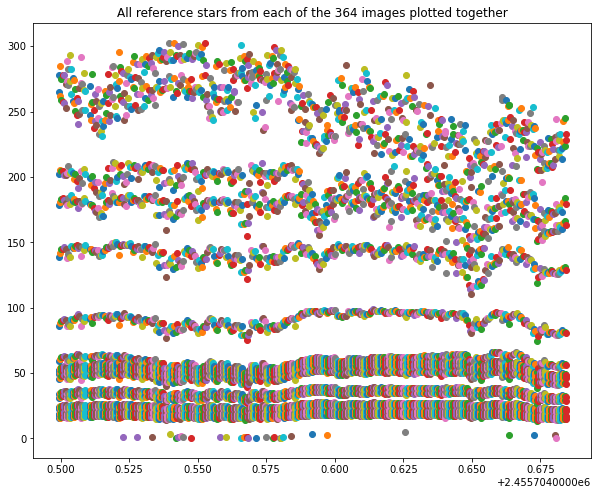

In [401]:
plt.figure(figsize=(10,8))
plt.title("All reference stars from each of the 364 images plotted together")
for x, y in zip(time_headers_copy, total_ref_flux_copy):
    plt.scatter([x] * len(y), y)

In [402]:
index = []

for k in range(5):
    for image in range(len(total_ref_flux_copy)):
        iqrs = iqr(total_ref_flux_copy[image])
        lower = np.quantile(total_ref_flux_copy[image], 0.47) 
        upper = np.quantile(total_ref_flux_copy[image], 0.52)

        for i in range(len(total_ref_flux_copy[image])):
            if lower < total_ref_flux_copy[image][i] < upper:
                index.append(image)

iqr_flux = [total_ref_flux_copy[j] for j in index]
time = [time_headers_copy[n] for n in index]
#iqr_flux = np.delete(total_ref_flux_copy, index, axis=0)
#time = np.delete(time_headers_copy, index, axis=0)
target_iqr_flux = [target_flux_copy[m] for m in index]

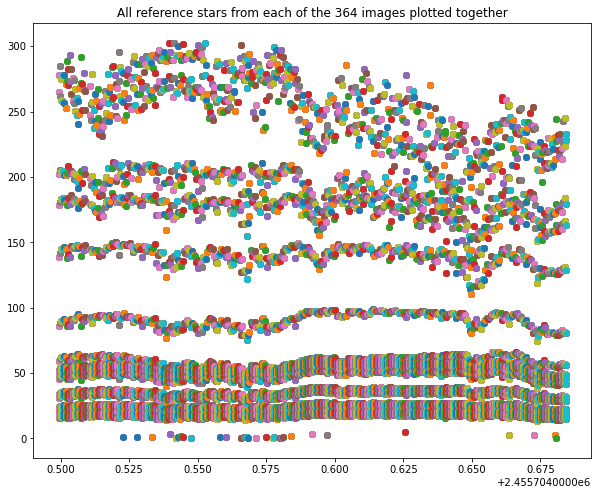

In [403]:
plt.figure(figsize=(10,8))
plt.title("All reference stars from each of the 364 images plotted together")
for x, y in zip(time, iqr_flux):
    plt.scatter([x] * len(y), y)
plt.savefig("all ref stars.pdf")

In [404]:
# Sky Correction
total_ref_median = []
for i in range(len(iqr_flux)):
    medians = np.median(iqr_flux[i])
    total_ref_median.append(medians)
total_ref_median = (np.array(total_ref_median) / np.sum(total_ref_median)) * np.sum(target_iqr_flux)

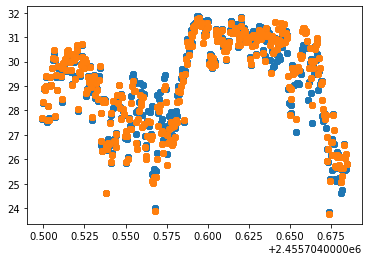

In [405]:
plt.scatter(time, total_ref_median)
plt.scatter(time, target_iqr_flux)

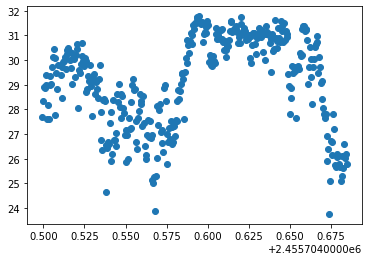

In [406]:
plt.scatter(time_headers_copy, target_flux_copy)

In [407]:
#lightcurve = target_flux_copy / total_ref_median
corrected_lightcurve = target_iqr_flux / total_ref_median

pos = []
for i in range(len(corrected_lightcurve)):
    if corrected_lightcurve[i] > 1.01 or corrected_lightcurve[i] < 0.97:
        pos.append(i)

corrected_lightcurve = np.delete(corrected_lightcurve, pos)
time = np.delete(np.array(time) - 2455704.000, pos)

In [408]:
bins = np.arange(min(time), max(time), (max(time)-min(time))/(len(time)/15))
bin_mean, bin_edges, bin_num = binned_statistic(time, corrected_lightcurve, statistic='mean', bins=bins)
bin_error, bin_edges, bin_num = binned_statistic(time, corrected_lightcurve, statistic='std', bins=bins)

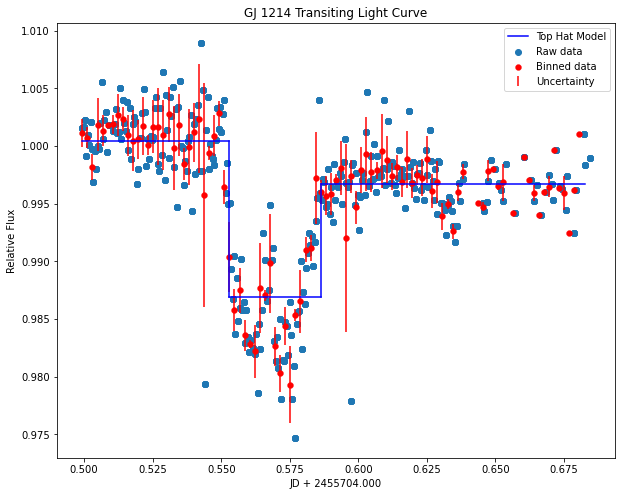

In [410]:
plt.figure(figsize=(10,8))
plt.scatter(time, corrected_lightcurve, label="Raw data")
plt.scatter(bin_edges[:-1], bin_mean, c='r',  linewidths=0.3, label="Binned data")
plt.errorbar(bin_edges[:-1], bin_mean, yerr=bin_error, ecolor='r', ls='None', label="Uncertainty")
plt.plot(bin_edges[:30], np.repeat(np.mean(bin_mean[0:30]), len(bin_num[:30])), c='b', label="Top Hat Model")
plt.plot(bin_edges[29:48], np.repeat(np.mean(bin_mean[29:48]), len(bin_num[29:48])), c='b')
plt.plot(bin_edges[47:], np.repeat(np.mean([x for x in bin_mean[47:] if (math.isnan(x) == False)]), 53), c='b')
plt.plot(np.repeat(bin_edges[29], 2), np.array([np.mean(bin_mean[0:30]), np.mean(bin_mean[29:48])]), c='b')
plt.plot(np.repeat(bin_edges[47], 2), np.array([np.mean(bin_mean[29:48]), np.mean([x for x in bin_mean[47:] if (math.isnan(x) == False)])]), c='b')
plt.title("GJ 1214 Transiting Light Curve")
plt.xlabel("JD + 2455704.000")
plt.ylabel("Relative Flux")
plt.legend()
plt.savefig("light curve.pdf")

In [354]:
first = np.mean(bin_mean[0:30])
dip = np.mean(bin_mean[29:48])
last = np.mean([x for x in bin_mean[47:] if (math.isnan(x) == False)])

print("Relative dip in flux is approximately", np.average([(first-dip), (last-dip)]) * 100, "%")

Relative dip in flux is approximately 1.167743411647576 %


### The $R_p$ and $R_{*}$ relationship

In [360]:
delta_f = np.average([(first-dip), (last-dip)])
f = first
r_star = 0.2064 # +/- 0.01, units of solar radii
delta = (delta_f / f)

rp = r_star * np.sqrt(delta) # units of solar radii
print(rp)
print("Radius of the planet is approximately 0.02 times radius of the Sun")

0.022299457477439694
Radius of the planet is approximately 0.02 times radius of the Sun


In [364]:
planet_mass = 8.17 # +/- 0.43, units of Earth mass
earth_mass = 5.972e27 # grams
solar_radii = 6.957e10 # cm
density = planet_mass*earth_mass / (4*np.pi*(rp*solar_radii)**3/3)
print("The planet's density is approximately", density, "g/cm^3")

The planet's density is approximately 3.11963902488225 g/cm^3
